<a href="https://colab.research.google.com/github/Shubhamd13/NLP/blob/main/8_1_Lottery_Ticket_Hypothesis_Student_Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Utility

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
def plot_weights(weights, title):
    fig, ax = plt.subplots()
    ax.imshow(weights == 0, vmin=0, vmax=1, cmap='summer')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

    # Annotate each cell with the weight value (even if 0)
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            ax.text(j, i, f"{weights[i, j]:.2f}", ha='center', va='center', color='black')

    # Add spacing between the cells. Adjust the value as needed.
    ax.set_xticks(np.arange(-0.5, weights.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, weights.shape[0], 1), minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=1)

    plt.show()

## Step 2: Initializing a Single MLP

(100, 8) (100, 10)


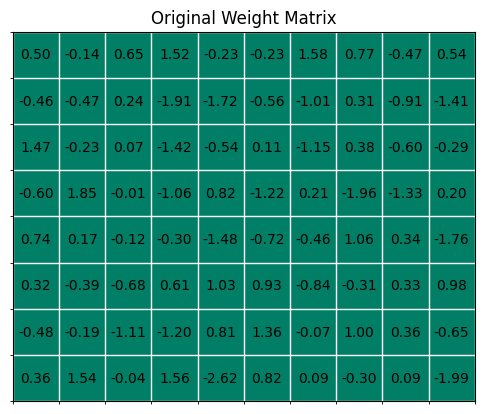

In [3]:
# simple linear mapping
random.seed(42)
np.random.seed(42)

# Initialize MLP layer with random weights w0
input_dim = 8
output_dim = 10

w0 = np.random.randn(input_dim, output_dim)  # weight initialization (will be used for rewinding)

X = np.random.randn(100, input_dim) # input to the MLP layer
y = X @ w0 + 0.1 * np.random.randn(100, output_dim)  # output of the MLP Layer
print(X.shape, y.shape)

plot_weights(w0, "Original Weight Matrix")

In [4]:
# Find the maximum value
max_val = np.max(w0)
print("Max value:", max_val)

Max value: 1.8522781845089378


## Step 3: Stochastic Gradient Descent

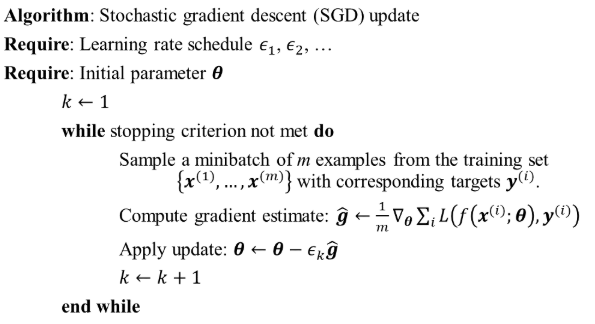

In [5]:
# Simple training function (SGD for k epochs)
def train(weights, mask, epochs=10, lr=0.1):
    w = weights.copy()
    for epoch in range(epochs):
        preds = X @ w
        grad = X.T @ (preds - y) / len(X)
        w = w - lr * grad
        w = w * mask  # Apply mask after each step
    return w

## Step 4: Iterative Magnitude Pruning (IMP)

Algorithm:

1. Initialize DNN with random weights w0.

2. While the sparsity level has not reached:

  a. Train the DNN with k epochs until convergence

  b. prune p% of the nonzero weights.

  c. Reinitialize the remaining weights using the values in w0, finetune the
  remaining weights for k epochs (Rewind).

3. Return the weights.


Iteration 1


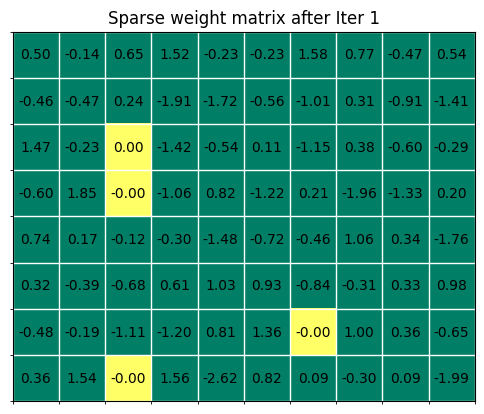

Threshold 0.08422634729803362
Sparsity: 5.00%

Iteration 2


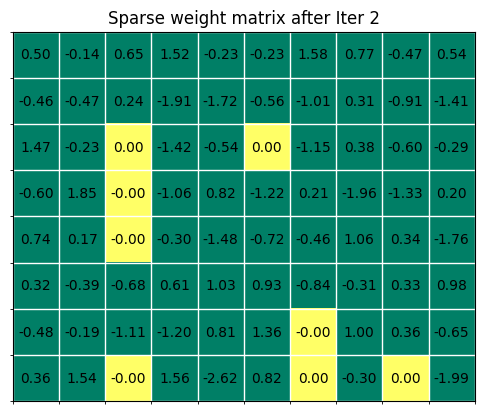

Threshold 0.1373633820388257
Sparsity: 10.00%

Iteration 3


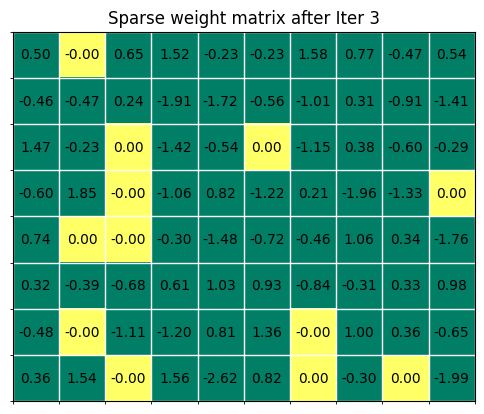

Threshold 0.197892256503519
Sparsity: 15.00%

Iteration 4


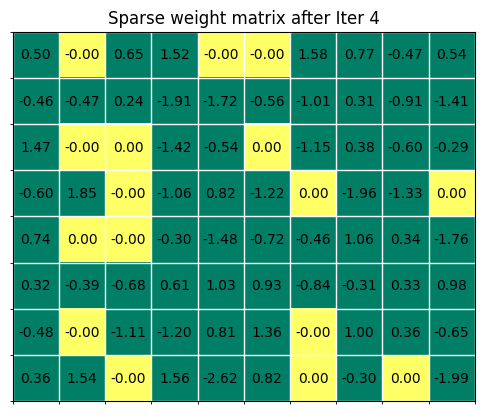

Threshold 0.24576573030789414
Sparsity: 20.00%


In [7]:
def iterative_magnitude_pruning(w0, prune_percent, num_iters, epochs):
    weights = w0.copy()
    mask = np.ones_like(weights)

    for iteration in range(num_iters):
        print(f"\nIteration {iteration + 1}")

        # Train with current mask
        weights = train(weights, mask, epochs=epochs)

        # Apply pruning only to the currently unpruned weights

        ###<--- Write code here
        unpruned_weights =  weights[mask == 1] # Only take the weights value where mask is 1
        ###

        if len(unpruned_weights) == 0:
            print("All weights pruned.")
            break

        # Compute threshold to prune p% of remaining weights
        threshold = np.quantile(np.abs(unpruned_weights), prune_percent)
        new_mask = (np.abs(weights) >= threshold).astype(float)

        # Update mask (prune additional weights)

        ###<--- Write code here
        mask =  mask * new_mask                 # update mask value
        weights =  w0 * mask                   # Rewind operation
        ###

        # Plot and report
        plot_weights(weights, f"Sparse weight matrix after Iter {iteration + 1}")
        print(f"Threshold {threshold}")
        remaining = np.count_nonzero(mask)
        total = mask.size
        print(f"Sparsity: {(1 - remaining / total) * 100:.2f}%")

    # Final training on winning ticket
    final_weights = train(weights, mask, epochs=epochs)
    return final_weights, mask

final_weights, final_mask = iterative_magnitude_pruning(w0, prune_percent=0.05, num_iters=4, epochs=10)

## Step 5: Mean Squared Error

Formula for MSE,

$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$


$n$: number of samples

$y_i$: true value for the $i$-th sample

$\hat{y}_i$: predicted value for the $i$-th sample

In [8]:
# Train dense model (no pruning)
dense_mask = np.ones_like(w0)
trained_dense_weights = train(w0.copy(), dense_mask, epochs=10)

# MSE before Pruning
dense_preds = X @ trained_dense_weights
dense_mse = np.mean((dense_preds - y) ** 2)
print("MSE without pruning:", dense_mse)

# MSE after Pruning

###<--- Write code here
preds =   X @ (trained_dense_weights * final_mask)                # Multiply input with pruned weight matrix
###

mse = np.mean((preds - y) ** 2)
print("MSE with pruning:", mse)

MSE without pruning: 0.009171799912731251
MSE with pruning: 0.04201203304717798


## Step 6: Performance Comparison

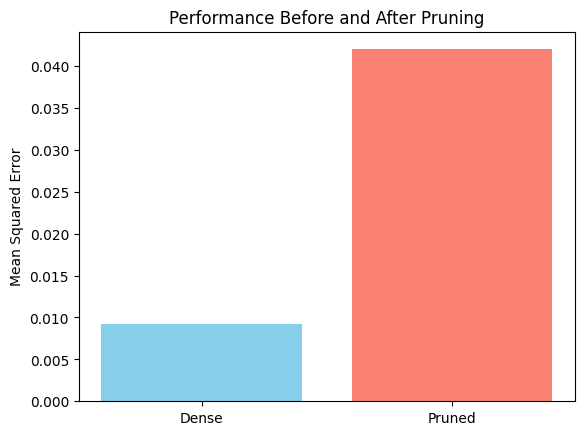

In [9]:
def plot_mse_curve(dense_mse, pruned_mse):
    fig, ax = plt.subplots()
    ax.bar(["Dense", "Pruned"], [dense_mse, pruned_mse], color=['skyblue', 'salmon'])
    ax.set_ylabel("Mean Squared Error")
    ax.set_title("Performance Before and After Pruning")
    plt.show()

plot_mse_curve(dense_mse, mse)